In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [4]:
import tensorflow as tf
 
import os
import time
import datetime
 
from matplotlib import pyplot as plt
from IPython import display

from src.data_loader import data_loader, preprocess_test_image
from src.networks import pix2pix_generator

In [6]:
generator = pix2pix_generator()
generator.load_weights("../saved_models/pix2pix/pix2pix.keras")

In [11]:
_, test_ds = data_loader()

1/1 [==============================] - 5s 5s/step


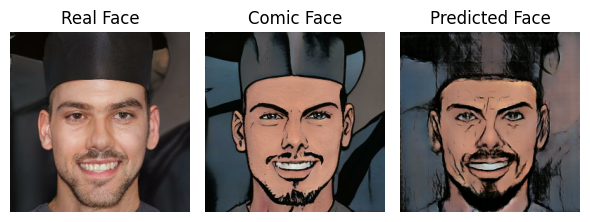

1/1 [==============================] - 0s 57ms/step


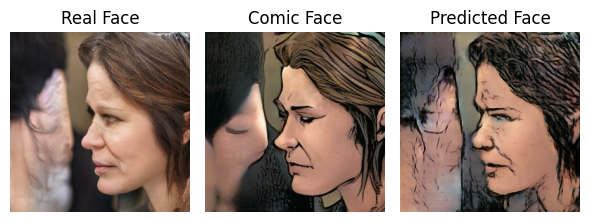

1/1 [==============================] - 0s 56ms/step


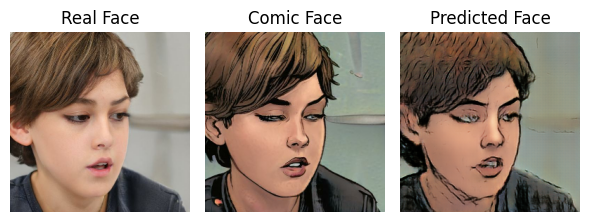

1/1 [==============================] - 0s 56ms/step


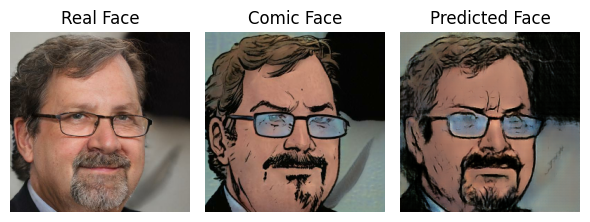

1/1 [==============================] - 0s 51ms/step


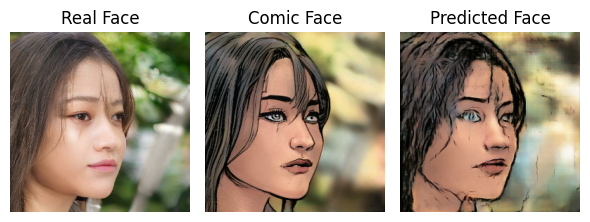

In [12]:
for inp, tar in test_ds.take(5):
    
    p = generator.predict(inp)

    plt.figure(figsize=(6, 3))

    display_list = [inp[0], tar[0], p[0]]
    title = ['Real Face', 'Comic Face', 'Predicted Face']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()